In [212]:
%matplotlib inline


# A upper-level Potential Vorticity Hemispheric Map using Python


This example plots a hemispheric plot of GFS Potential Vorticity interpolated on upper-level surface


In [16]:
# =======
# modules

# time
from datetime import datetime, timedelta
# plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# metpy
import metpy.calc as mpcalc
from metpy.units import units
# netcdf4
from netCDF4 import num2date
# useful 
import numpy as np
import scipy.ndimage as ndimage 
import xarray as xr
from xarray.backends import NetCDF4DataStore
# weather data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS


CPU times: user 111 µs, sys: 26 µs, total: 137 µs
Wall time: 147 µs


In [218]:
# =======
# define Dataset and Time

# Set the time range
now = datetime.utcnow() #current
end = now + timedelta(days=7) # end of forecast
dt = 8 # take only every nth time: 8 x 3h = 1 day

# set geography
north = 90; south = 0; east = 360; west = 0

# define dataset from THREDDS catalog 
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best_gfs = cat.datasets['Best GFS Half Degree Forecast Time Series']
print(best_gfs)

# available THREDDS catalog 
#cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
#print('available THREDDS catalog: ', list(cat.catalog_refs))

Best GFS Half Degree Forecast Time Series


In [219]:
%%time
# =======
# Best GFS Dataset

# Create NCSS object to access the NetcdfSubset
subset_access = best_gfs.subset()

# Query for Best GFS Run

# variables needed for potential vorticity
query = subset_access.query().time_range(now, end).strides(time=dt).lonlat_box(west=west, east=east, south=south, north=north).accept('netcdf4')    # use time(now) to get only current timestep
query.variables('Temperature_isobaric','u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')

# Actually getting (request) the data
#data_geopot = ncss.get_data(query_geopot)
#data_wind = ncss.get_data(query_wind)
data = subset_access.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))
data = data.metpy.parse_cf()

CPU times: user 3.53 s, sys: 785 ms, total: 4.31 s
Wall time: 4min 13s


In [220]:
# =======
# Data Retrieval

# available variables
print(sorted(list(data.variables)))

# Grab lat/lon values (GFS will be 1D)
lats = data.lat.values
lons = data.lon.values

# Create a clean datetime object for plotting based on time of forecast
vtime = data.time.data.astype('datetime64[ms]').astype('O')
print(vtime)
# Grab the variables
# Need all pressure levels for Temperatures, U and V Wind
press = data['isobaric'][:].values * units('Pa')
temperature = data['Temperature_isobaric'][:]
uwnd = data['u-component_of_wind_isobaric'][:] 
vwnd = data['v-component_of_wind_isobaric'][:] 

# NOTE: different number of vertical pressure levels for temperature(isobaric6) and wind(isobaric)
# print('Shape of Temperature ' + str(temperature.shape) + ' is not equal to shape of wind ' + str(uwnd.shape) + '!')
# remove abundant vertical levels in temperature
# select only where isobaric6 = isobaric
temperature = temperature.metpy.sel(vertical=press)

# Due to a different number of vertical levels find where they are common
#_, _, common_ind = np.intersect1d(uwnd.dimensions[1], lev_temperature.dimensions[1], return_indices=True)


['LatLon_Projection', 'Temperature_isobaric', 'crs', 'isobaric', 'isobaric6', 'lat', 'lon', 'reftime', 'time', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric']
[datetime.datetime(2019, 12, 21, 15, 0)
 datetime.datetime(2019, 12, 22, 15, 0)
 datetime.datetime(2019, 12, 23, 15, 0)
 datetime.datetime(2019, 12, 24, 15, 0)
 datetime.datetime(2019, 12, 25, 15, 0)
 datetime.datetime(2019, 12, 26, 15, 0)
 datetime.datetime(2019, 12, 27, 15, 0)]


In [287]:
# =======
# Calculate Potential Vorticity on all pressure levels

# Compute dx and dy spacing for use in vorticity calculation
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# calculate potential temperature theta
theta = mpcalc.potential_temperature(press[None,:, None, None], temperature)

# Comput the PV on all isobaric surfaces
pv = mpcalc.potential_vorticity_baroclinic(theta, press[None, :, None, None], uwnd, vwnd,
                                           dx[None, None, :, :], dy[None, None, :, :],
                                           lats[None, None, :, None] * units('degrees'))
# =======
# Interpolate PV on isentropic or isobaric surface and change unit to PVU

# isobaric surface
#i250 = list(press.m).index(((250 * units('hPa')).to(press.units)).m)
#pv = pv[:,i250]*1e6

# isentropic surface
isentlevs = np.arange(315, 320, 5) * units.kelvin
isent_anal = mpcalc.isentropic_interpolation(isentlevs, press, temperature.values*units.kelvin, pv*1e6, axis=1)
pv = isent_anal[1]

# vertical average if multiple surfaces
pv = pv.mean(axis=1)


# Smooth using a gaussian filter from scipy.ndimage
pv, clons = cutil.add_cyclic_point(pv, coord=lons)
pv = ndimage.gaussian_filter(pv[:, :, :], sigma=1, order=0)

In [288]:
# =======
# Prepare famous ETH PV colorbar

from matplotlib.colors import from_levels_and_colors
# define levels and colormap
levels = [-1, 0, 0.5, 1.0, 1.5, 2.0, 2.5,3,4, 5, 6, 8.0]
colors = [ # Daniel 11 colors
            [145, 172, 243], #blue
            [176, 198, 235], # light blue
            [211, 228, 235], # white blue
            [245, 220, 177], # white sand
            [233, 192, 140], # dark sand
            [255, 69, 0],      #red
            [250, 122, 0], #orange
            [255,168,0],
            [248, 205, 2], #gold
            [249, 248, 7], #gelb
            [121, 188, 85]   #green
        ]  
# convert RGB values to range between 0 - 1
colors = np.array(colors)/255
# creat colormap
cmap, norm = from_levels_and_colors(levels, colors, extend='neither')


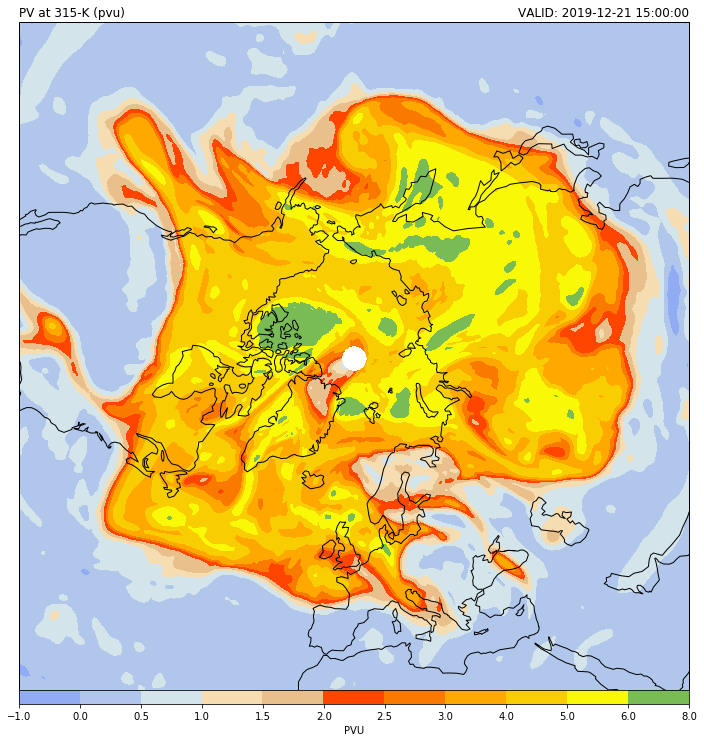

In [289]:
# =======
# Plotting on a map

# Set up the projection
datacrs = ccrs.PlateCarree()                           # projecetion of the data
plotcrs = ccrs.NorthPolarStereo(central_longitude=0.0) # wanted projection

# Make a grid of lat/lon values to use for plotting with Basemap.
clon, clat = np.meshgrid(clons, lats)

fig = plt.figure(1, figsize=(12., 13.))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02],
                       bottom=.07, top=.99, hspace=0.01, wspace=0.01)

ax = plt.subplot(gs[0], projection=plotcrs)

# ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
ax.coastlines(edgecolor='black', linewidth=1)

cs1 = ax.contourf(clon, clat, pv[0], levels=levels, cmap=cmap, norm=norm,
                 transform=datacrs)
cbar = plt.colorbar(cs1, orientation='horizontal', pad=0, aspect=50, extendrect=True)
cbar.set_ticks(levels)
cbar.set_label('PVU')

# plot title
ax.set_title('PV at 315-K (pvu)', loc='left')
ax.set_title('VALID: {}'.format(vtime[0]), loc='right')

plt.show()

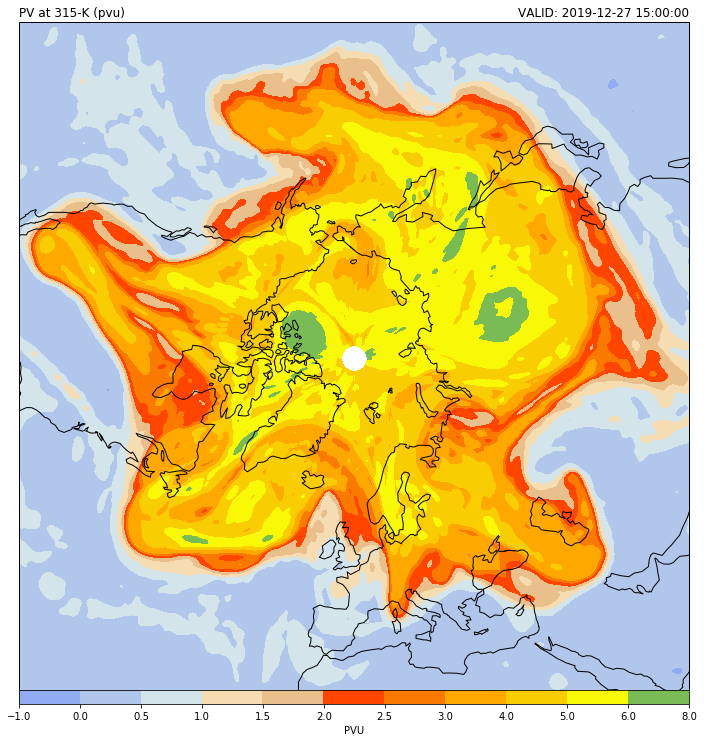

In [290]:
# =======
# plot as animation

from matplotlib import animation

nframes = 7 #number of frames per cycle
seconds = 14. #desired duration
interval = seconds/nframes


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(1, figsize=(12., 13.))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02],
                       bottom=.07, top=.99, hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)
# ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
ax.coastlines(edgecolor='black', linewidth=1)

# initialization function: plot the background of each frame

#No initialization needed
def init():
    return 

# animation function.  This is called sequentially
def animate(i):
    cs1 = ax.contourf(clon, clat, pv[i], levels=levels, cmap=cmap, norm=norm,
                 transform=datacrs)
    
    # plot title
    ax.set_title('PV at 315-K (pvu)', loc='left')
    ax.set_title('VALID: {}'.format(vtime[i]), loc='right')
    return

cbar = plt.colorbar(cs1, orientation='horizontal', pad=0, aspect=50, extendrect=True)
cbar.set_ticks(levels)
cbar.set_label('PVU')

#Animate it and save!
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=nframes, interval=interval, 
                               blit=False)
anim.save('anim.gif', dpi=200, fps = 1/interval, writer='imagemagick')
